# The VIX and realised volatility: a test of lagged and contemporaneous relationships

### Based on *The VIX, VXO and realised volatility: a test of lagged and contemporaneous relationships* by B.Adhikari and J.Hilliard, Int. J. Financial Markets and Derivatives, Vol. 3, No. 3, 2014

## Import, wrangle and save Dataset

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests as granger
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats import stattools as tool
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR, VECM
import scipy.stats as stat
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox


In [7]:
#Import Datasets
CBOE = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/RawData/VIX.csv')
CBOE['date']=pd.to_datetime(CBOE.Date,infer_datetime_format=True).dt.strftime('%Y%m%d').astype(int)

In [8]:
CBOE

,Date,vixo,vixh,vixl,vix,vxoo,vxoh,vxol,vxo,vxno,vxnh,vxnl,vxn,date
0,02JAN1996,13.39,13.39,12.19,12.19,14.46,14.46,13.16,13.25,NaN,NaN,NaN,NaN,19960102
1,03JAN1996,11.53,12.29,11.45,12.10,13.07,13.41,12.66,12.74,NaN,NaN,NaN,NaN,19960103
2,04JAN1996,11.24,14.23,11.23,13.78,13.07,15.45,12.91,14.00,NaN,NaN,NaN,NaN,19960104
3,05JAN1996,14.02,14.74,13.55,13.58,15.03,15.89,13.77,13.87,NaN,NaN,NaN,NaN,19960105
4,08JAN1996,14.02,13.22,12.44,13.11,14.08,14.23,12.87,12.94,NaN,NaN,NaN,NaN,19960108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5535,22DEC2017,9.37,10.18,9.35,9.90,8.60,8.95,8.35,8.45,13.12,13.14,12.48,12.54,20171222
5536,26DEC2017,10.19,10.46,10.13,10.25,9.22,9.26,7.83,7.83,14.33,14.35,13.56,13.64,20171226
5537,27DEC2017,10.04,10.79,9.71,10.47,9.06,9.16,8.42,8.90,14.06,14.44,13.75,14.29,20171227
5538,28DEC2017,10.29,10.44,10.07,10.18,8.79,8.81,7.86,8.43,14.29,14.66,14.12,14.62,20171228


In [284]:
CBOE = CBOE[['date','vix']]
CBOE.vix = CBOE.vix/100

priceSPX = pd.read_csv('/home/student/surface/Realized Variance/DatasetSPX/RawData/PriceSPX.csv')
priceSPX = priceSPX[['date','close']]

#Compute returns
priceSPX['ret'] = np.log(priceSPX['close']/priceSPX['close'].shift(1))

#Merge Dataset
dataset = pd.merge(CBOE,priceSPX[['date','ret']])

#Convert Index to Datetime
dataset.index = pd.to_datetime(priceSPX.date,format='%Y%m%d')

In [285]:
#Compute realVol as a std() of 30 effective calendar days window ~aprx. 21 trading days 
dataset['realVol'] = dataset.ret.rolling('30d').std()*365**0.5
dataset.realVol = dataset.realVol.shift(freq='-30d')

In [286]:
#Assign a stamp representing the month and the year univocally. Will be used to sift 1 observation per month. 
dataset['stamp']  = dataset.index.month  + dataset.index.year*100
dataset = dataset['1996-03-01':'2012-12-31']
#Filter our any NaN values
dataset.dropna(inplace=True)
#We keep the first available occurrance as the obervation of that month. 
#In fact the first month observation is the std of the next 30days,
#hence representing fully and only that given month.
dataset.drop_duplicates(inplace=True,subset='stamp',keep='first')

In [287]:
dataset

,date,vix,ret,realVol,stamp
date,,,,,
1996-03-04,19960304,0.1667,0.009945,0.176484,199603
1996-04-01,19960401,0.1790,0.012669,0.122788,199604
1996-05-01,19960501,0.1607,0.000627,0.141790,199605
1996-06-03,19960603,0.1686,-0.002154,0.089656,199606
1996-07-01,19960701,0.1378,0.007798,0.199521,199607
...,...,...,...,...,...
2012-08-01,20120801,0.1896,-0.002904,0.109567,201208
2012-09-04,20120904,0.1798,-0.001167,0.133975,201209
2012-10-01,20121001,0.1632,0.002648,0.131473,201210


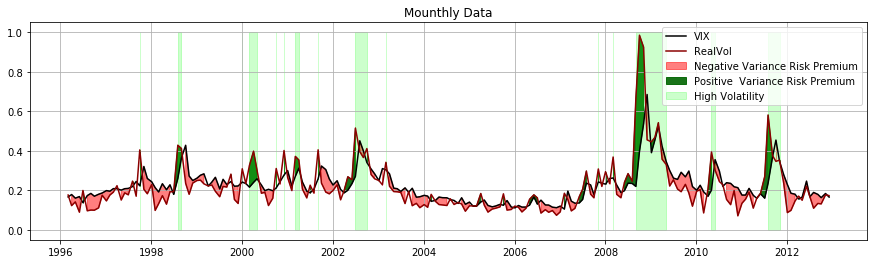

Linear Correlation VIX-RealVol: 0.6971153970640058
P-value: 1.0096925138682117e-30


In [288]:
#Plot Data
plt.figure(figsize=(15,4))
plt.plot(dataset[['vix']],c='k')
plt.plot(dataset[['realVol']],c='darkred')
plt.grid(True)
plt.title('Mounthly Data')
plt.fill_between(dataset.index,dataset.vix, dataset.realVol,color='red',alpha=0.5, where=dataset.vix>dataset.realVol)
plt.fill_between(dataset.index,dataset.vix, dataset.realVol,color='darkgreen',alpha=0.9, where=dataset.vix<dataset.realVol)
plt.fill_between(dataset.index,1,color='lime',alpha=0.2, where=dataset.realVol>0.3)
plt.legend(['VIX','RealVol','Negative Variance Risk Premium','Positive  Variance Risk Premium','High Volatility (>0.3)'])
plt.show()
correlation = stat.pearsonr(dataset.vix,dataset.realVol)
print('Linear Correlation VIX-RealVol: ' + str(correlation[0]) + '\nP-value: ' + str(correlation[1]))

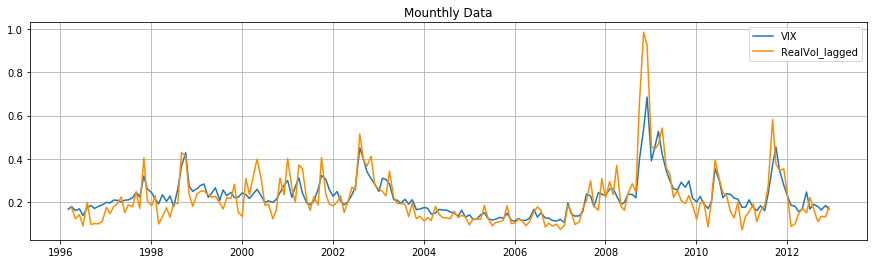

Linear Correlation VIX-RealVol: 0.8790746570048187
P-value: 5.959567708031647e-66


In [289]:
#Plot Data
plt.figure(figsize=(15,4))
plt.plot(dataset[['vix']])
plt.plot(dataset[['realVol']].shift(1),color='darkorange')
plt.legend(['VIX','RealVol_lagged'])
plt.grid(True)
plt.title('Mounthly Data')
plt.show()
correlation = stat.pearsonr(dataset.vix[1:],dataset.realVol.shift(1)[1:])
print('Linear Correlation VIX-RealVol: ' + str(correlation[0]) + '\nP-value: ' + str(correlation[1]))

Note that turning points in RV consistently lead turning points in IV.This is confirmed in the above figure where RV is lagged one month. Essentially we plot December RV versus the January VIX (the 21 trading day forward date from the December VIX) and so forth. The peaks appear to be almost coincident and the pairwise correlation of VIX with lagged RV is 0.8825 versus the previous correlation of 0.718

/home/student/anaconda3/envs/surface/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


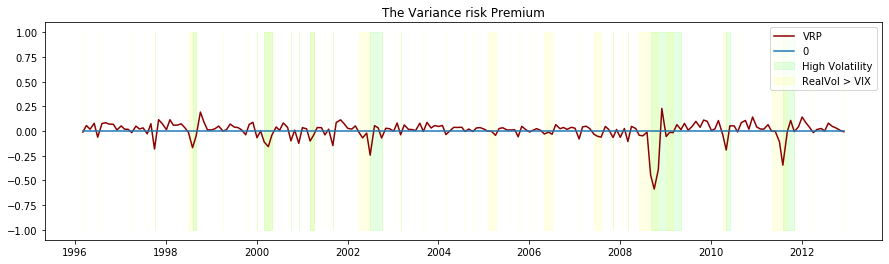

Average Variance Risk Premium: 0.7383%


In [290]:
plt.figure(figsize=(15,4))
dataset.VRP = dataset.vix - dataset.realVol
plt.plot(dataset.VRP, color='darkred')
plt.plot(dataset.index,np.zeros(len(dataset.index)))
plt.fill_between(dataset.index,1,-1,color='lime',alpha=0.1, where=dataset.realVol>0.3)
plt.fill_between(dataset.index,1,-1,color='yellow',alpha=0.1, where=dataset.realVol>dataset.vix)
plt.title('The Variance risk Premium')
plt.legend(['VRP','0','High Volatility','RealVol > VIX'])
plt.show()
print('Average Variance Risk Premium: {}%'.format(round(dataset.VRP.mean()*100,4)))

# Econometric analysis

### DATASET EXPLORATION

In [220]:
dataset[['vix','realVol']].describe().T

,count,mean,std,min,25%,50%,75%,max
vix,261.0,0.205320,0.082044,0.094500,0.146700,0.192600,0.238900,0.685100
realVol,261.0,0.196385,0.119371,0.056463,0.121249,0.174494,0.229525,0.984725


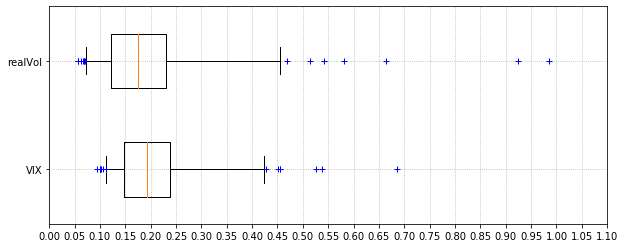

In [221]:
plt.figure(figsize=(10,4))
plt.boxplot(dataset[['vix','realVol']].T,notch=False,whis=[2.5,97.5],bootstrap=10000,\
            widths=0.5,vert=False,labels=['VIX','realVol'],sym='b+')
plt.grid(True,linestyle=':')
plt.xticks(np.linspace(0.,1.1,23))
plt.show()

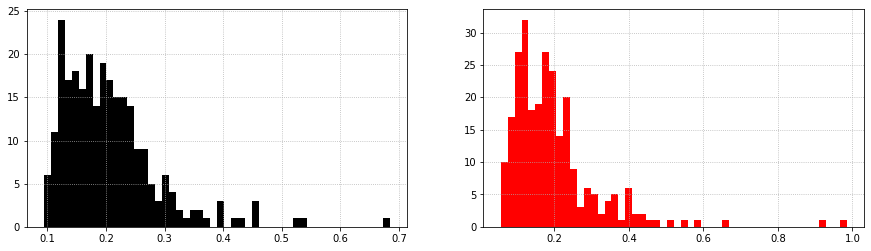

In [222]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(dataset.vix, bins=50, color='k')
plt.grid(True,linestyle=':')
plt.subplot(1,2,2)
plt.hist(dataset.realVol, bins=50, color='r')
plt.grid(True,linestyle=':')
plt.show()

**QQ-PLOTS**

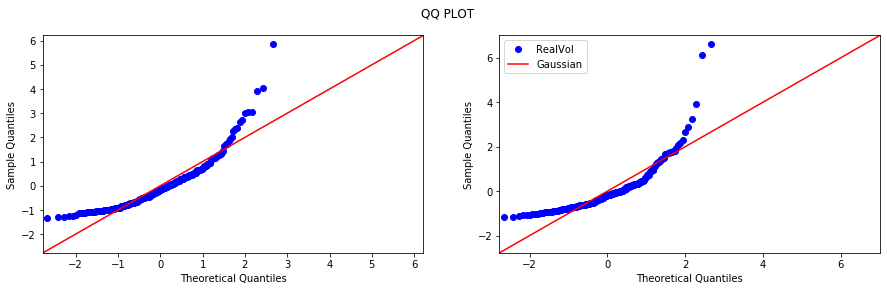

In [223]:
fig, (ax, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,4)) # create two subplots, one in each row
qq_vix = qqplot(dataset.vix,fit=True,line='45',ax=ax)
plt.legend(('VIX','Gaussian'))
qq_realVol = qqplot(dataset.realVol,fit=True,line='45',ax=ax2)
plt.suptitle('QQ PLOT')
plt.legend(('RealVol','Gaussian'))
plt.show()

**LINEAR CORRELATION**

In [224]:
correlation = stat.pearsonr(dataset.vix,dataset.realVol)
print('Linear Correlation VIX-RealVol: ' + str(correlation[0]) + '\nP-value: ' + str(correlation[1]))

Linear Correlation VIX-RealVol: 0.7156521512823224
P-value: 2.956328617244204e-42


**ACF & PACF**

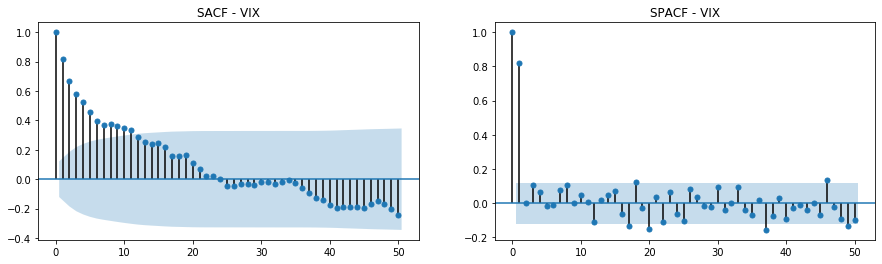

,1,2,3,4,5,6,7,8,9,10
Ljung-Box Stat,176.472,294.8952,384.8641,458.2226,514.9351,557.3100,594.1228,632.1642,667.9502,701.7587
Ljung-Box P-Value,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Box-Pierce Stat,174.459,291.0811,379.3396,451.0244,506.2275,547.3134,582.8665,619.4615,653.7507,686.0166
Box-Pierce P-Value,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [225]:
fig, (ax, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,4)) # create two subplots, one in each row
acf_vix = plot_acf(dataset.vix,lags=50,ax=ax,title='SACF - VIX')
acf_realVol = plot_pacf(dataset.vix,lags=50,ax=ax2,title='SPACF - VIX')
plt.show()
pd.DataFrame(np.round(np.array(acorr_ljungbox(dataset.vix,lags=10,boxpierce=True)),4),\
             columns=range(1,11,1),index=('Ljung-Box Stat','Ljung-Box P-Value','Box-Pierce Stat','Box-Pierce P-Value'))

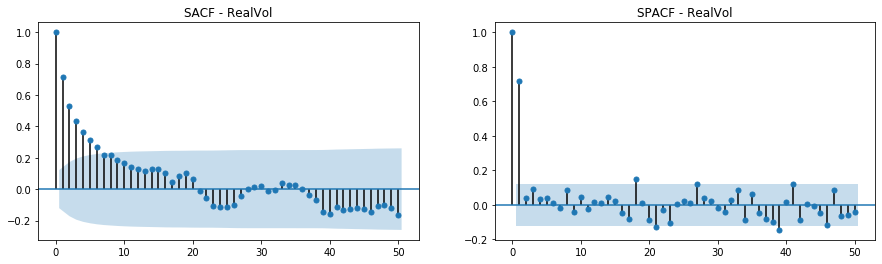

,1,2,3,4,5,6,7,8,9,10
Ljung-Box Stat,134.6935,208.6326,258.4263,293.4643,319.9330,339.5090,352.2411,365.0088,374.0881,381.9311
Ljung-Box P-Value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Box-Pierce Stat,133.1570,205.9716,254.8186,289.0573,314.8216,333.8021,346.0985,358.3807,367.0802,374.5654
Box-Pierce P-Value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [226]:
fig, (ax, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,4)) # create two subplots, one in each row
acf_vix = plot_acf(dataset.realVol,lags=50,ax=ax,title='SACF - RealVol')
acf_realVol = plot_pacf(dataset.realVol,lags=50,ax=ax2,title='SPACF - RealVol')
plt.show()
pd.DataFrame(np.round(np.array(acorr_ljungbox(dataset.realVol,lags=10,boxpierce=True)),4),\
             columns=range(1,11,1),index=('Ljung-Box Stat','Ljung-Box P-Value','Box-Pierce Stat','Box-Pierce P-Value'))

### TEST STATIONARITY AND UNIT ROOT

In [227]:
print('VIX\nKPSS Test for Non-Stationarity\n\nH0: time-series is stationary \nH1: time-series is not stationary\n')
kpss_test = kpss(dataset.vix,lags='auto')
print('KPSS stat is '+str(kpss_test[0])[:5] + '.\nThe 10% threshold is ' + str(kpss_test[3]['10%'])+ '.\nThe 5% threshold is ' + str(kpss_test[3]['5%']) + '.\nThe 1% threshold is ' + str(kpss_test[3]['1%'])+'. \nThe null hypothesys is rejected at 5% confidence level.\nP-value is: ' + str(round(kpss_test[1],4)) +'\n\n' )
print('AugmentedDickeyFuller Test for Stationarity\n\nHo: time-series has unit root\nH0: time-series has  NO unit root\n')
adf_test = adfuller(dataset.vix,autolag='BIC')
print('ADF stat is '+str(adf_test[0])[:5] + '.\nThe 10% threshold is ' + str(adf_test[4]['10%'])+ '.\nThe 5% threshold is ' + str(adf_test[4]['5%'])+ '.\nThe 1% threshold is ' + str(adf_test[4]['1%']) +'. \nThe null hypothesys is rejected at 1% confidence level.\nP-value is: ' + str(round(adf_test[1],4)) + '\n') 

VIX
KPSS Test for Non-Stationarity

H0: time-series is stationary 
H1: time-series is not stationary

KPSS stat is 0.395.
The 10% threshold is 0.347.
The 5% threshold is 0.463.
The 1% threshold is 0.739. 
The null hypothesys is rejected at 5% confidence level.
P-value is: 0.079


AugmentedDickeyFuller Test for Stationarity

Ho: time-series has unit root
H0: time-series has  NO unit root

ADF stat is -4.97.
The 10% threshold is -2.572728476331361.
The 5% threshold is -2.8727214497041422.
The 1% threshold is -3.4557539868570775. 
The null hypothesys is rejected at 1% confidence level.
P-value is: 0.0



In [228]:
print('RealVol\nKPSS Test for Non-Stationarity\n\nH0: time-series is stationary \nH1: time-series is not stationary\n')
kpss_test = kpss(dataset.realVol,lags='auto')
print('KPSS stat is '+str(kpss_test[0])[:5] + '.\nThe 10% threshold is ' + str(kpss_test[3]['10%'])+ '.\nThe 5% threshold is ' + str(kpss_test[3]['5%']) + '.\nThe 1% threshold is ' + str(kpss_test[3]['1%'])+'. \nThe null hypothesys cannot be rejected at 5% confidence level.\nP-value is: ' + str(round(kpss_test[1],4)) +'\n\n' )
print('AugmentedDickeyFuller Test for Stationarity\n\nHo: time-series has unit root\nH0: time-series has  NO unit root\n')
adf_test = adfuller(dataset.realVol,autolag='BIC')
print('ADF stat is '+str(adf_test[0])[:5] + '.\nThe 10% threshold is ' + str(adf_test[4]['10%'])+ '.\nThe 5% threshold is ' + str(adf_test[4]['5%'])+ '.\nThe 1% threshold is ' + str(adf_test[4]['1%']) +'. \nThe null hypothesys is rejected at 1% confidence level.\nP-value is: ' + str(round(adf_test[1],4)) + '\n') 

RealVol
KPSS Test for Non-Stationarity

H0: time-series is stationary 
H1: time-series is not stationary

KPSS stat is 0.259.
The 10% threshold is 0.347.
The 5% threshold is 0.463.
The 1% threshold is 0.739. 
The null hypothesys cannot be rejected at 5% confidence level.
P-value is: 0.1


AugmentedDickeyFuller Test for Stationarity

Ho: time-series has unit root
H0: time-series has  NO unit root

ADF stat is -6.49.
The 10% threshold is -2.572728476331361.
The 5% threshold is -2.8727214497041422.
The 1% threshold is -3.4557539868570775. 
The null hypothesys is rejected at 1% confidence level.
P-value is: 0.0



/home/student/anaconda3/envs/surface/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


### FIT VAR(p) MODEL USING BIC

In [229]:
#Lag selection for VIX model
model = VAR(dataset[['vix','realVol']])
result = model.select_order(trend='c')

/home/student/anaconda3/envs/surface/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [230]:
result.summary()

,AIC,BIC,FPE,HQIC
0,-9.870,-9.842,5.168e-05,-9.859
1,-11.86,-11.77*,7.068e-06,-11.83*
2,-11.87,-11.73,7.002e-06,-11.81
3,-11.88*,-11.68,6.913e-06*,-11.80
4,-11.87,-11.61,7.025e-06,-11.76
5,-11.84,-11.53,7.218e-06,-11.71
6,-11.82,-11.45,7.373e-06,-11.67
7,-11.86,-11.43,7.102e-06,-11.68
8,-11.85,-11.37,7.136e-06,-11.66
9,-11.85,-11.31,7.153e-06,-11.63


In [231]:
result = model.fit(maxlags=15,ic='bic',trend='c')
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 01, Dec, 2019
Time:                     18:49:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.8537
Nobs:                     260.000    HQIC:                  -11.9028
Log likelihood:           819.816    FPE:                6.55109e-06
AIC:                     -11.9359    Det(Omega_mle):     6.40249e-06
--------------------------------------------------------------------
Results for equation vix
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.043441         0.005314            8.175           0.000
L1.vix             0.387809         0.034203           11.339           0.000
L1.realVol         0.417841         0.023481           17.795           0.

**STABILITY**

In [232]:
print('\nThe estimated VAR is stable:  ' + str(result.is_stable(verbose=True)))

Eigenvalues of VAR(1) rep
0.33893412761088504
0.7453855105735562

The estimated VAR is stable:  True


### RESIDUAL ANALISYS

**ACF of model's residuals**

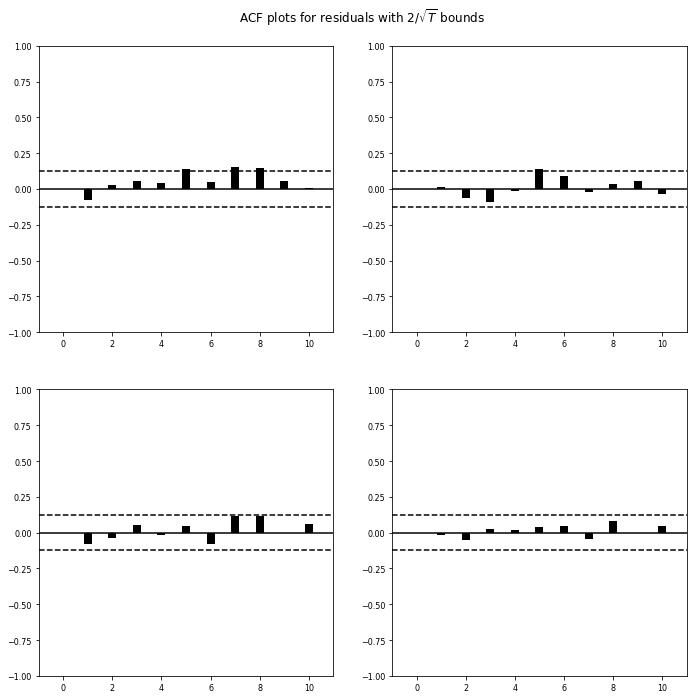

In [233]:
result.plot_acorr()
plt.show()

**Test on residuals autocorrelation**

In [234]:
#VIX
#H0: Autocorrelation coefficients up to lag M are equal to zero
#H1: At least 1 lag up to lag M is statistacally different from zero

pd.DataFrame(np.round(np.array(acorr_ljungbox(result.resid.vix,lags=10,boxpierce=True)),4),\
             columns=range(1,11,1),index=('Ljung-Box Stat','Ljung-Box P-Value','Box-Pierce Stat','Box-Pierce P-Value'))

,1,2,3,4,5,6,7,8,9,10
Ljung-Box Stat,1.6734,1.9026,2.7629,3.3024,8.7402,9.3079,15.4385,21.1512,22.0624,22.0703
Ljung-Box P-Value,0.1958,0.3862,0.4296,0.5086,0.1199,0.1570,0.0308,0.0068,0.0087,0.0148
Box-Pierce Stat,1.6543,1.8799,2.7238,3.2509,8.5435,9.0938,15.0138,20.5085,21.3815,21.3890
Box-Pierce P-Value,0.1984,0.3906,0.4362,0.5167,0.1287,0.1684,0.0358,0.0086,0.0111,0.0185


In [235]:
#RealVol
#H0: Autocorrelation coefficients up to lag M are equal to zero
#H1: At least 1 lag up to lag M is statistacally different from zero

pd.DataFrame(np.round(np.array(acorr_ljungbox(result.resid.realVol,lags=10,boxpierce=True)),4),\
             columns=range(1,11,1),index=('Ljung-Box Stat','Ljung-Box P-Value','Box-Pierce Stat','Box-Pierce P-Value'))

,1,2,3,4,5,6,7,8,9,10
Ljung-Box Stat,0.0622,0.7638,0.9600,1.0651,1.5443,2.1384,2.7440,4.5262,4.5273,5.0296
Ljung-Box P-Value,0.8031,0.6826,0.8109,0.8998,0.9079,0.9065,0.9076,0.8068,0.8734,0.8892
Box-Pierce Stat,0.0615,0.7524,0.9448,1.0475,1.5139,2.0899,2.6746,4.3888,4.3899,4.8692
Box-Pierce P-Value,0.8042,0.6865,0.8146,0.9025,0.9115,0.9112,0.9134,0.8204,0.8839,0.8997


**Test on squared-residuals autocorrelation**

Text(0.5, 0.98, 'VIX Squared-Residuals')

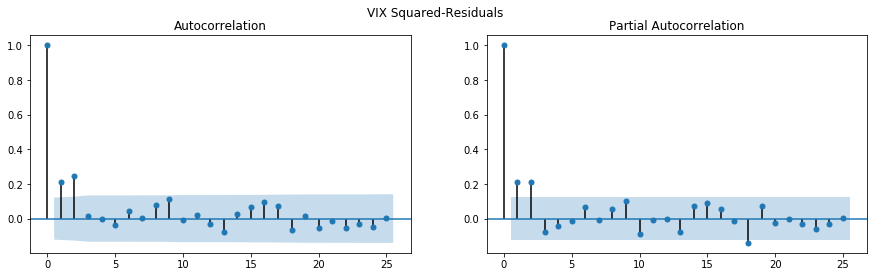

In [236]:
fig, (ax, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,4)) # create two subplots, one in each row
plot_acf(np.power(result.resid.vix.values,2),ax=ax)
plot_pacf(np.power(result.resid.vix.values,2),ax=ax2)
plt.suptitle('VIX Squared-Residuals')

In [237]:
#VIX
#H0: Autocorrelation coefficients up to lag M are equal to zero
#H1: At least 1 lag up to lag M is statistacally different from zero
pd.DataFrame(np.round(np.array(acorr_ljungbox(np.power(result.resid.vix.values,2),lags=10,boxpierce=True)),4),\
             columns=range(1,11,1),index=('Ljung-Box Stat','Ljung-Box P-Value','Box-Pierce Stat','Box-Pierce P-Value'))

,1,2,3,4,5,6,7,8,9,10
Ljung-Box Stat,11.6825,27.3988,27.4397,27.4398,27.7587,28.2171,28.2172,29.8173,33.2064,33.2362
Ljung-Box P-Value,0.0006,0.0000,0.0000,0.0000,0.0000,0.0001,0.0002,0.0002,0.0001,0.0002
Box-Pierce Stat,11.5488,27.0251,27.0652,27.0653,27.3757,27.8201,27.8202,29.3592,32.6060,32.6345
Box-Pierce P-Value,0.0007,0.0000,0.0000,0.0000,0.0000,0.0001,0.0002,0.0003,0.0002,0.0003


Text(0.5, 0.98, 'RealVol Squared-Residuals')

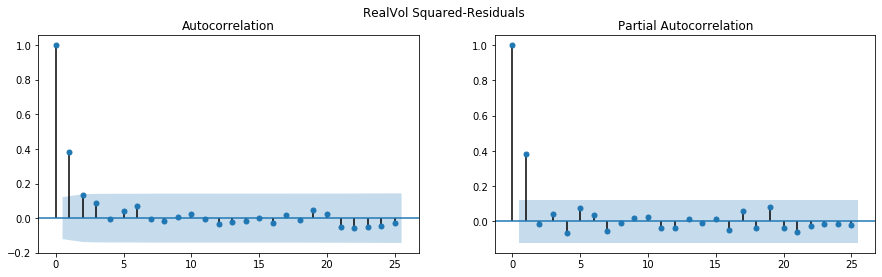

In [238]:
fig, (ax, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,4)) # create two subplots, one in each row
plot_acf(np.power(result.resid.realVol.values,2),ax=ax)
plot_pacf(np.power(result.resid.realVol.values,2),ax=ax2)
plt.suptitle('RealVol Squared-Residuals')

In [239]:
#RealVol
#H0: Autocorrelation coefficients up to lag M are equal to zero
#H1: At least 1 lag up to lag M is statistacally different from zero
pd.DataFrame(np.round(np.array(acorr_ljungbox(np.power(result.resid.realVol,2),lags=10,boxpierce=True)),4),\
             columns=range(1,11,1),index=('Ljung-Box Stat','Ljung-Box P-Value','Box-Pierce Stat','Box-Pierce P-Value'))

,1,2,3,4,5,6,7,8,9,10
Ljung-Box Stat,38.4567,43.3491,45.3051,45.3170,45.7814,47.0538,47.0614,47.1182,47.1299,47.2525
Ljung-Box P-Value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Box-Pierce Stat,38.0163,42.8340,44.7527,44.7643,45.2163,46.4499,46.4572,46.5119,46.5231,46.6400
Box-Pierce P-Value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


**Whiteness of Residuals**

In [240]:
result.test_whiteness(5).summary()

Test statistic,Critical value,p-value,df
19.86,26.30,0.227,16


**QQ-Plot of model's residuals**

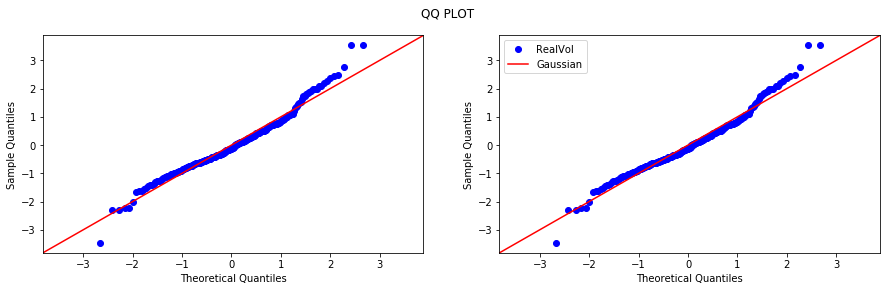

In [241]:
fig, (ax, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,4)) # create two subplots, one in each row
qq_vix = qqplot(result.resid.vix,fit=True,line='45',ax=ax)
plt.legend(('VIX','Gaussian'))
qq_realVol = qqplot(result.resid.vix,fit=True,line='45',ax=ax2)
plt.suptitle('QQ PLOT')
plt.legend(('RealVol','Gaussian'))
plt.show()

**Empirical Distribution of standardized model residuals**

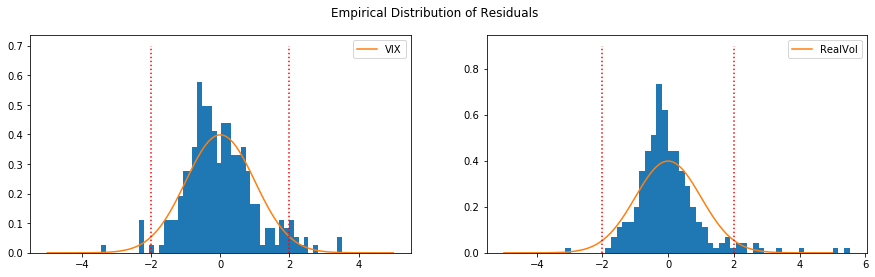

vix    93.846154
dtype: float64
realVol    95.0
dtype: float64


In [242]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
res_vix = (result.resid.vix-result.resid.vix.mean())/result.resid.vix.std()
plt.hist(res_vix,density=True ,bins=50)
x = np.linspace(-5, 5, 100)
plt.plot(x, stat.norm.pdf(x, 0, 1))
plt.legend(['VIX'])
plt.plot([-2,-2],[0,0.7],'r:')
plt.plot([2,2],[0,0.7],'r:')
res_vix = pd.DataFrame(res_vix)
plt.subplot(1,2,2)
res_realVol=(result.resid.realVol-result.resid.realVol.mean())/result.resid.realVol.std()
plt.hist(res_realVol,density=True, bins=50)
plt.plot(x, stat.norm.pdf(x, 0, 1))
plt.legend(['RealVol'])
plt.plot([-2,-2],[0,0.9],'r:')
plt.plot([2,2],[0,0.9],'r:')
plt.suptitle('Empirical Distribution of Residuals')
res_realVol = pd.DataFrame(res_realVol)
plt.show()
print(res_vix[(res_vix.vix<=2) & (res_vix.vix>=-2)].count()/res_vix.count()*100)
print(res_realVol[(res_realVol.realVol<=2) & (res_realVol.realVol>=-2)].count()/res_realVol.count()*100)

**Jarque-Bera Test**

In [243]:
jb_test = tool.jarque_bera(res_vix.vix)
print('\nThe Jarque-Bera test statistic: {} \nThe p-value of  test statistic: {} \nEstimated Skewness: {} \nEstimated Kurtosis: {}\n\n'.format(jb_test[0],jb_test[1],jb_test[2],jb_test[3]))
if jb_test[1]<0.01:
    print('Null hypothesis of Normality of residuals is rejected at 1% confidence level')
else:
    print('Failed to reject Null hypothesis of Normality of residuals at 1% confidence level ')


The Jarque-Bera test statistic: 25.486670407018664 
The p-value of  test statistic: 2.9217283867960655e-06 
Estimated Skewness: 0.47246232086690576 
Estimated Kurtosis: 4.208194169545141


Null hypothesis of Normality of residuals is rejected at 1% confidence level


In [244]:
jb_test = tool.jarque_bera(res_realVol.realVol)
print('\nThe Jarque-Bera test statistic: {} \nThe p-value of  test statistic: {} \nEstimated Skewness: {} \nEstimated Kurtosis: {}\n\n'.format(jb_test[0],jb_test[1],jb_test[2],jb_test[3]))
if jb_test[1]<0.01:
    print('Null hypothesis of Normality of residuals is rejected at 1% confidence level')
else:
    print('Failed to reject Null hypothesis of Normality of residuals at 1% confidence level ')


The Jarque-Bera test statistic: 669.532936585389 
The p-value of  test statistic: 4.099870076034836e-146 
Estimated Skewness: 1.7862224890313674 
Estimated Kurtosis: 10.002904910028702


Null hypothesis of Normality of residuals is rejected at 1% confidence level


**Squared-Residual Plot**

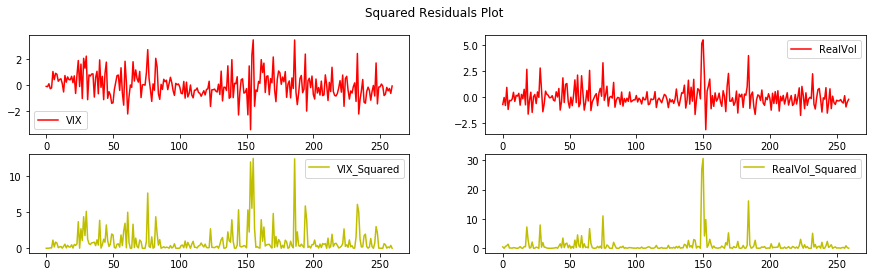

In [245]:
plt.figure(figsize=(15,4))
plt.suptitle('Squared Residuals Plot')
plt.subplot(221)
plt.plot(np.power(res_vix.vix.values,1),color='r')
plt.legend(['VIX'])
plt.subplot(222)
plt.plot(np.power(res_realVol.realVol.values,1),color='r')
plt.legend(['RealVol'])
plt.subplot(223)
plt.plot(np.power(res_vix.vix.values,2),color='y')
plt.legend(['VIX_Squared'])
plt.subplot(224)
plt.plot(np.power(res_realVol.realVol.values,2),color='y')
plt.legend(['RealVol_Squared'])

### CAUSALITY

**IMPULSE RESPONSE FUNCTION**

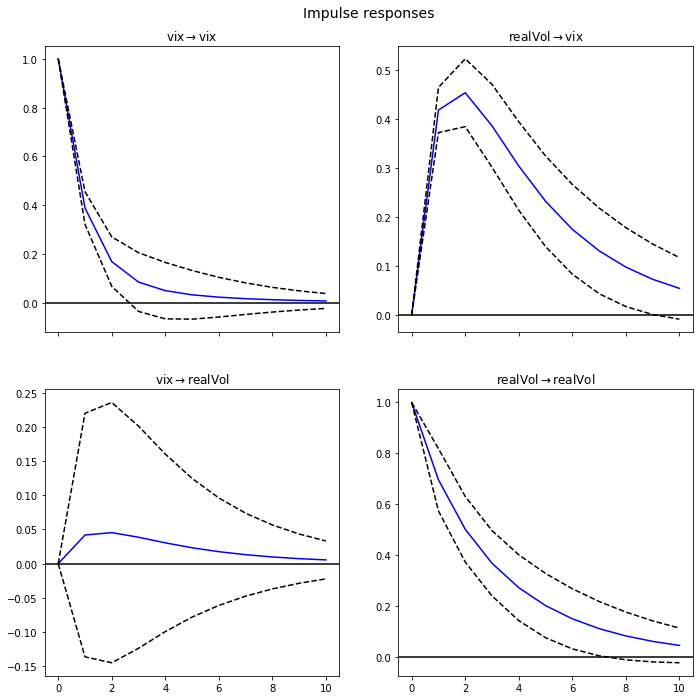

In [246]:
irf = result.irf()
irf.plot();

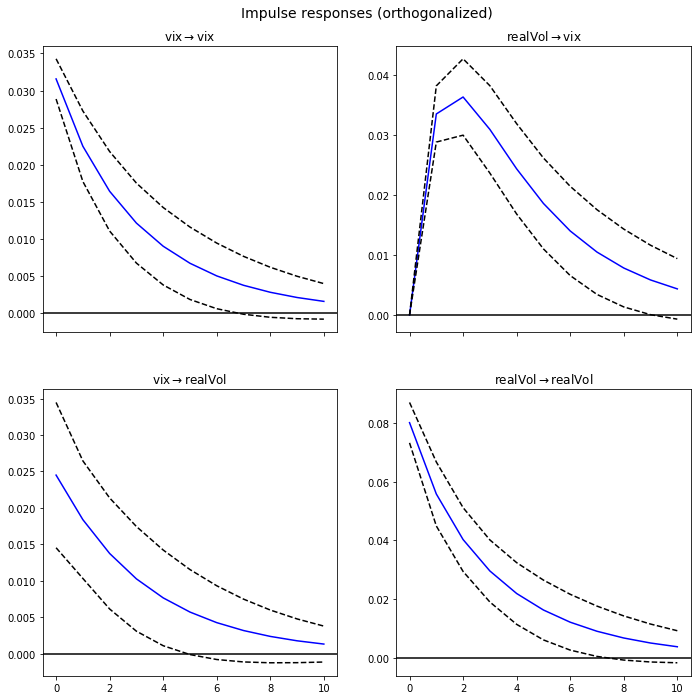

In [247]:
irf.plot(orth=True);

**CUMULATIVE IMPULSE RESPONSE FUNCTION**

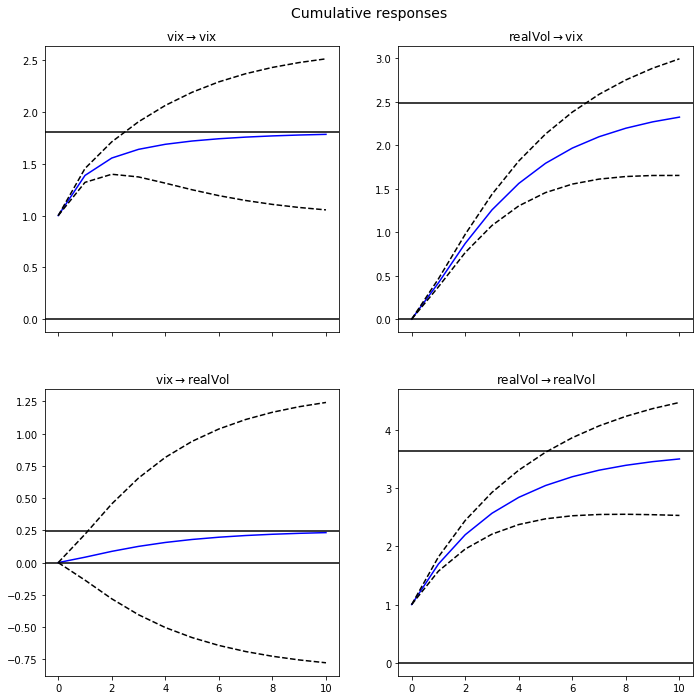

In [248]:
irf.plot_cum_effects(orth=False,);

**VARIANCE DECOMPOSITION**

In [249]:
fevd = result.fevd()
fevd.summary()

FEVD for vix
          vix   realVol
0    1.000000  0.000000
1    0.572375  0.427625
2    0.420403  0.579597
3    0.360742  0.639258
4    0.333623  0.666377
5    0.320201  0.679799
6    0.313227  0.686773
7    0.309500  0.690500
8    0.307476  0.692524
9    0.306365  0.693635

FEVD for realVol
          vix   realVol
0    0.085396  0.914604
1    0.089480  0.910520
2    0.091653  0.908347
3    0.092811  0.907189
4    0.093434  0.906566
5    0.093772  0.906228
6    0.093957  0.906043
7    0.094058  0.905942
8    0.094114  0.905886
9    0.094145  0.905855




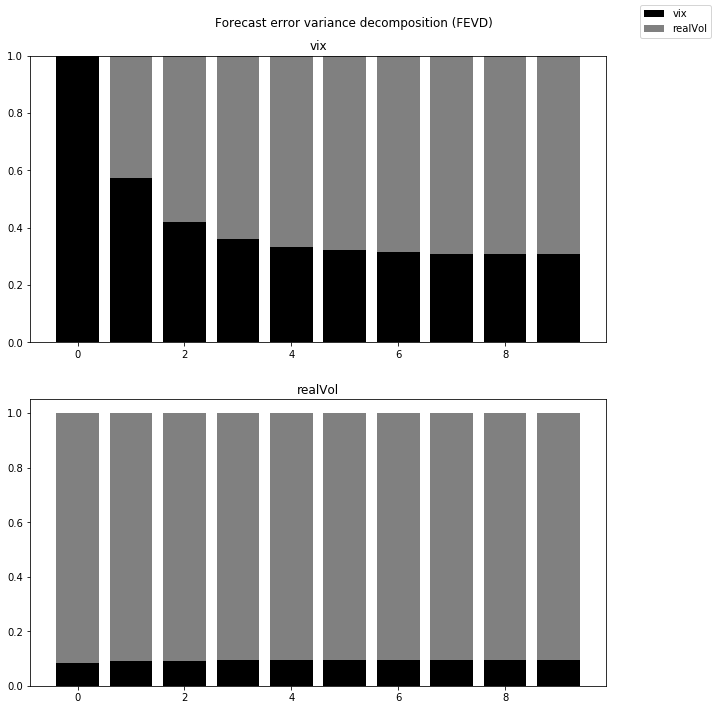

In [250]:
fevd.plot();

In [251]:
inst_caus = result.test_inst_causality('vix')
inst_caus.summary()

Test statistic,Critical value,p-value,df
20.46,3.841,0.000,1


In [252]:
inst_caus = result.test_inst_causality('realVol')
inst_caus.summary()

Test statistic,Critical value,p-value,df
20.46,3.841,0.000,1


In [253]:
granger1 = granger(dataset[['vix','realVol']].values,10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=316.6683, p=0.0000  , df_denom=257, df_num=1
ssr based chi2 test:   chi2=320.3649, p=0.0000  , df=1
likelihood ratio test: chi2=208.7736, p=0.0000  , df=1
parameter F test:         F=316.6683, p=0.0000  , df_denom=257, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=166.3126, p=0.0000  , df_denom=254, df_num=2
ssr based chi2 test:   chi2=339.1730, p=0.0000  , df=2
likelihood ratio test: chi2=216.7965, p=0.0000  , df=2
parameter F test:         F=166.3126, p=0.0000  , df_denom=254, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=114.7253, p=0.0000  , df_denom=251, df_num=3
ssr based chi2 test:   chi2=353.7745, p=0.0000  , df=3
likelihood ratio test: chi2=222.7583, p=0.0000  , df=3
parameter F test:         F=114.7253, p=0.0000  , df_denom=251, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=86.2829 , p=0.0000  

In [254]:
granger(dataset[['realVol','vix']].values,10);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2121  , p=0.6455  , df_denom=257, df_num=1
ssr based chi2 test:   chi2=0.2146  , p=0.6432  , df=1
likelihood ratio test: chi2=0.2145  , p=0.6433  , df=1
parameter F test:         F=0.2121  , p=0.6455  , df_denom=257, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3996  , p=0.2486  , df_denom=254, df_num=2
ssr based chi2 test:   chi2=2.8544  , p=0.2400  , df=2
likelihood ratio test: chi2=2.8388  , p=0.2419  , df=2
parameter F test:         F=1.3996  , p=0.2486  , df_denom=254, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8744  , p=0.4549  , df_denom=251, df_num=3
ssr based chi2 test:   chi2=2.6962  , p=0.4409  , df=3
likelihood ratio test: chi2=2.6822  , p=0.4433  , df=3
parameter F test:         F=0.8744  , p=0.4549  , df_denom=251, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6442  , p=0.6315  

# VECM

In [264]:
vecm = VECM(dataset[['vix','realVol']],k_ar_diff=3,deterministic='co')

/home/student/anaconda3/envs/surface/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [265]:
result_vecm = vecm.fit()

In [266]:
result_vecm.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0192,0.003,5.841,0.000,0.013,0.026
L1.vix,-0.2824,0.065,-4.325,0.000,-0.410,-0.154
L1.realVol,0.0500,0.054,0.934,0.350,-0.055,0.155
L2.vix,-0.1908,0.056,-3.403,0.001,-0.301,-0.081
L2.realVol,0.0728,0.046,1.597,0.110,-0.017,0.162
L3.vix,-0.0880,0.041,-2.133,0.033,-0.169,-0.007
L3.realVol,0.0329,0.035,0.944,0.345,-0.035,0.101
,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0120,0.009,-1.302,0.193,-0.030,0.006
L1.vix,-0.4584,0.182,-2.515,0.012,-0.816,-0.101


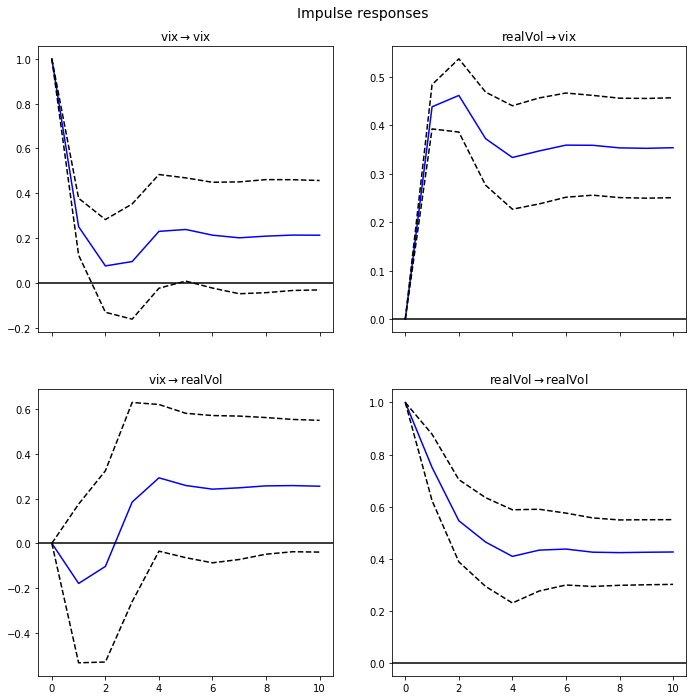

In [272]:
result_vecm.irf().plot();